In [1]:
import os
import pandas as pd
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [72]:
data = pd.read_sql("select * from sports_data.tourney_games_with_season_stats", conn)

In [73]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [74]:
predictor_columns = data.columns[8:-1]
predictors = data[predictor_columns]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [75]:
predictors_and_response.corr(numeric_only=True)['Win_Loss_Flag'].sort_values(ascending=False)

Win_Loss_Flag                                  1.000000
adj_offense_team                               0.270970
adj_defense_opponent                           0.225174
offensive_efficiency_team                      0.196490
opponent_offensive_efficiency_opponent         0.123610
effective_fg_percent_team                      0.116454
opponent_effective_fg_percent_opponent         0.112050
turnover_percent_opponent                      0.106504
offensive_rebound_percent_team                 0.104910
opponent_free_throw_rate_opponent              0.070684
free_throw_rate_opponent                       0.066086
opponent_turnover_percent_team                 0.033527
opponent_offensive_rebound_percent_opponent    0.001040
opponent_offensive_rebound_percent_team       -0.001040
opponent_turnover_percent_opponent            -0.033527
free_throw_rate_team                          -0.066086
opponent_free_throw_rate_team                 -0.070684
offensive_rebound_percent_opponent            -0

In [76]:
corrs = predictors_and_response.corr(numeric_only=True)['Win_Loss_Flag']
corrs = corrs[corrs > 0.02]
corrs = corrs[corrs.index != 'Win_Loss_Flag']
effective_predictors = corrs.index.tolist()

In [77]:
len(effective_predictors)

11

In [78]:
prediction_data = data[effective_predictors]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [79]:
prediction_data_normalized

,adj_offense_team,offensive_efficiency_team,effective_fg_percent_team,offensive_rebound_percent_team,opponent_turnover_percent_team,adj_defense_opponent,turnover_percent_opponent,free_throw_rate_opponent,opponent_offensive_efficiency_opponent,opponent_effective_fg_percent_opponent,opponent_free_throw_rate_opponent
0,-0.927835,-1.624681,-1.649647,-0.387095,0.617680,-0.591715,-0.114575,-0.058197,-0.464621,0.068223,-0.223741
1,-0.212381,-0.766889,-0.859129,0.315748,1.201215,-0.385921,-0.239694,-0.604433,-0.172103,-0.505183,0.359243
2,-0.195177,-0.715680,-0.196766,-0.101264,0.512527,-0.642958,0.836021,-0.578729,-0.571980,-0.983478,1.185184
3,1.053736,0.897114,0.248055,1.953495,0.069976,-0.749431,0.594703,0.817571,-0.412882,-0.499381,1.303525
4,-0.195177,-0.715680,-0.196766,-0.101264,0.512527,-0.790995,0.111636,-0.887965,-0.300158,-0.272603,-0.055341
...,...,...,...,...,...,...,...,...,...,...,...
1237,-1.426319,-0.604308,-0.281490,-0.531916,0.416185,0.157309,-0.374213,0.576946,0.324425,0.265386,1.252496
1238,0.367438,0.559941,1.489443,-1.255623,0.119701,0.328140,0.726266,1.420357,-0.523980,-0.440797,-0.824305
1239,-1.387000,-1.206570,-0.153137,-2.031117,-0.428632,-0.632140,0.312622,1.204664,-1.084201,-1.145650,-0.827130
1240,0.519922,0.775015,0.189707,0.712305,0.844513,0.025232,0.429733,0.886730,0.583046,0.949030,0.558894


In [80]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [81]:
data['predicted_outcome'] = clf.predict(prediction_data_normalized)

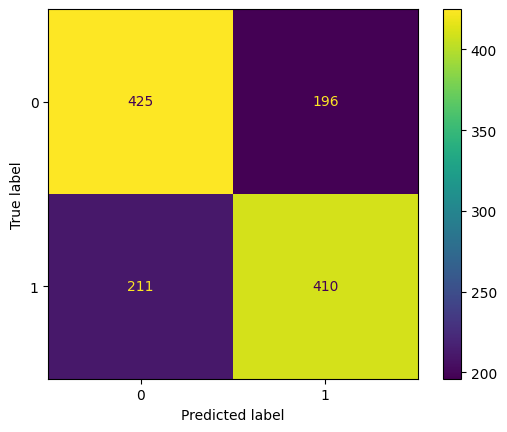

In [82]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], data['predicted_outcome'])).plot()

Logistic regression predicted 835 games correctly and got 407 wrong. Getting about 2/3 of the games right is not bad, but it's not great either. Other models might yield better results.

In [83]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, max_iter=3000).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [84]:
data['nn_predicted_outcome'] = clf.predict(prediction_data_normalized)

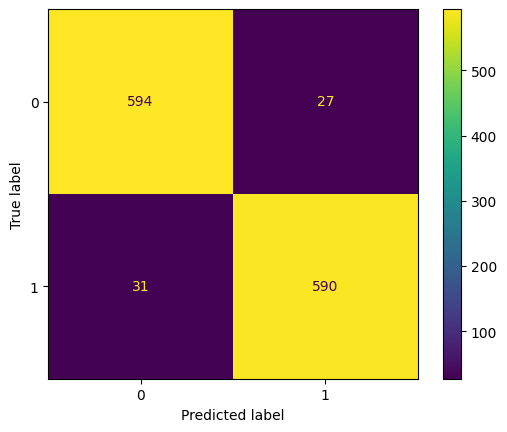

In [85]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], data['nn_predicted_outcome'])).plot()

NN did a lot better but there's probably some overfitting happening. Need to hold out a test set.

In [86]:
train_X = prediction_data_normalized.iloc[:int(len(prediction_data_normalized)*0.6)]
train_y = data['Win_Loss_Flag'].iloc[:int(len(prediction_data_normalized)*0.6)]
test_X = prediction_data_normalized.iloc[int(len(prediction_data_normalized)*0.6):]
test_y = data['Win_Loss_Flag'].iloc[int(len(prediction_data_normalized)*0.6):]

In [87]:
clf = MLPClassifier(hidden_layer_sizes=[50, 50, 50],random_state=0, max_iter=3000).fit(train_X, train_y)

In [88]:
nn_test_outcomes = clf.predict(test_X)

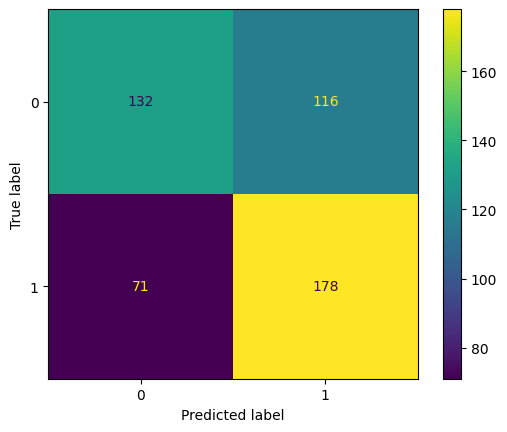

In [89]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(test_y, nn_test_outcomes)).plot()

In [17]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [91]:
cms = proper_cross_validation(MLPClassifier(hidden_layer_sizes=[50, 50, 50],random_state=0, max_iter=3000), prediction_data_normalized, data['Win_Loss_Flag'])

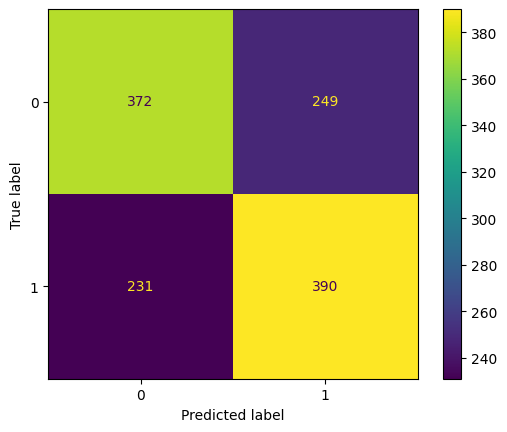

In [92]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

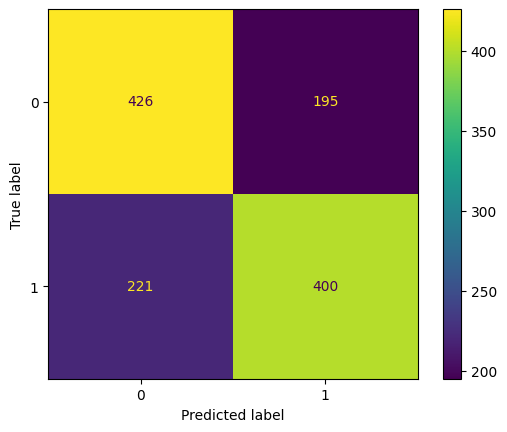

In [93]:
# and what about the logistic regression model?
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [94]:
# well, they're both getting things right a little under 70% of the time
# could try different models, but better indicators is probably the more effective way to go
all_games = pd.read_sql("select * from sports_data.game_stats_v2", conn)

In [95]:
all_games.columns

Index(['date', 'game_type', 'team', 'conference', 'opponent', 'location',
       'result', 'adj_offense', 'adj_defense', 'offensive_efficiency',
       'effective_fg_percent', 'turnover_percent', 'offensive_rebound_percent',
       'free_throw_rate', 'opponent_offensive_efficiency',
       'opponent_effective_fg_percent', 'opponent_turnover_percent',
       'opponent_offensive_rebound_percent', 'opponent_free_throw_rate',
       'opponent_conference', 'season', 'Win_Loss', 'score', 'opponent_score'],
      dtype='object')

In [96]:
team_conference_affiliation = all_games[['team', 'conference', 'season']].drop_duplicates(subset=['team', 'season'], keep='first')

In [97]:
len(data.columns)

35

In [99]:
data = pd.merge(data, team_conference_affiliation, left_on=['team', 'season'], right_on=['team', 'season'])

In [101]:
data['conference']

0       P12
1       B12
2       SEC
3        BE
4       SEC
       ... 
1237     SC
1238    MVC
1239    MWC
1240    P12
1241     BE
Name: conference, Length: 1242, dtype: object

In [2]:
data = pd.read_sql("select * from sports_data.tourney_games_v4", conn)

In [3]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [4]:
data.columns

Index(['season', 'last_5_win_loss_ratio_opponent', 'team',
       'last_5_win_loss_ratio', 'vs_tourney_team_win_loss_ratio_opponent',
       'games_played_vs_tourney_team_opponent',
       'vs_tourney_team_win_loss_ratio', 'games_played_vs_tourney_team',
       'opponent', 'last_10_win_loss_ratio_opponent', 'last_10_win_loss_ratio',
       'date', 'location', 'Win_Loss', 'score', 'opponent_score',
       'adj_offense_team', 'adj_defense_team', 'offensive_efficiency_team',
       'effective_fg_percent_team', 'turnover_percent_team',
       'offensive_rebound_percent_team', 'free_throw_rate_team',
       'opponent_offensive_efficiency_team',
       'opponent_effective_fg_percent_team', 'opponent_turnover_percent_team',
       'opponent_offensive_rebound_percent_team',
       'opponent_free_throw_rate_team', 'adj_offense_opponent',
       'adj_defense_opponent', 'offensive_efficiency_opponent',
       'effective_fg_percent_opponent', 'turnover_percent_opponent',
       'offensive_rebound_

In [5]:
data.drop(columns=['losses', 'wins', 'losses_opponent', 'wins_opponent', 'conference'], inplace=True)

In [7]:
data.columns

Index(['season', 'last_5_win_loss_ratio_opponent', 'team',
       'last_5_win_loss_ratio', 'vs_tourney_team_win_loss_ratio_opponent',
       'games_played_vs_tourney_team_opponent',
       'vs_tourney_team_win_loss_ratio', 'games_played_vs_tourney_team',
       'opponent', 'last_10_win_loss_ratio_opponent', 'last_10_win_loss_ratio',
       'date', 'location', 'Win_Loss', 'score', 'opponent_score',
       'adj_offense_team', 'adj_defense_team', 'offensive_efficiency_team',
       'effective_fg_percent_team', 'turnover_percent_team',
       'offensive_rebound_percent_team', 'free_throw_rate_team',
       'opponent_offensive_efficiency_team',
       'opponent_effective_fg_percent_team', 'opponent_turnover_percent_team',
       'opponent_offensive_rebound_percent_team',
       'opponent_free_throw_rate_team', 'adj_offense_opponent',
       'adj_defense_opponent', 'offensive_efficiency_opponent',
       'effective_fg_percent_opponent', 'turnover_percent_opponent',
       'offensive_rebound_

In [8]:
predictor_cols = ['last_5_win_loss_ratio_opponent',
       'last_5_win_loss_ratio', 'vs_tourney_team_win_loss_ratio_opponent',
       'games_played_vs_tourney_team_opponent',
       'vs_tourney_team_win_loss_ratio', 'games_played_vs_tourney_team',
       'last_10_win_loss_ratio_opponent', 'last_10_win_loss_ratio',
       'adj_offense_team', 'adj_defense_team', 'offensive_efficiency_team',
       'effective_fg_percent_team', 'turnover_percent_team',
       'offensive_rebound_percent_team', 'free_throw_rate_team',
       'opponent_offensive_efficiency_team',
       'opponent_effective_fg_percent_team', 'opponent_turnover_percent_team',
       'opponent_offensive_rebound_percent_team',
       'opponent_free_throw_rate_team', 'adj_offense_opponent',
       'adj_defense_opponent', 'offensive_efficiency_opponent',
       'effective_fg_percent_opponent', 'turnover_percent_opponent',
       'offensive_rebound_percent_opponent', 'free_throw_rate_opponent',
       'opponent_offensive_efficiency_opponent',
       'opponent_effective_fg_percent_opponent',
       'opponent_turnover_percent_opponent',
       'opponent_offensive_rebound_percent_opponent',
       'opponent_free_throw_rate_opponent', 'win_loss_ratio',
       'win_loss_ratio_opponent', 'conference_strength',
       'conference_strength_opponent']

In [9]:
predictors = data[predictor_cols]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [10]:
predictors_and_response.corr(numeric_only=True)['Win_Loss_Flag']

last_5_win_loss_ratio_opponent                 0.017472
last_5_win_loss_ratio                         -0.017472
vs_tourney_team_win_loss_ratio_opponent       -0.386519
games_played_vs_tourney_team_opponent         -0.341582
vs_tourney_team_win_loss_ratio                 0.386519
games_played_vs_tourney_team                   0.341582
last_10_win_loss_ratio_opponent               -0.076102
last_10_win_loss_ratio                         0.076102
adj_offense_team                               0.270970
adj_defense_team                              -0.225174
offensive_efficiency_team                      0.196490
effective_fg_percent_team                      0.116454
turnover_percent_team                         -0.106504
offensive_rebound_percent_team                 0.104910
free_throw_rate_team                          -0.066086
opponent_offensive_efficiency_team            -0.123610
opponent_effective_fg_percent_team            -0.112050
opponent_turnover_percent_team                 0

In [11]:
prediction_data = data[predictor_cols]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [12]:
prediction_data_normalized

,last_5_win_loss_ratio_opponent,last_5_win_loss_ratio,vs_tourney_team_win_loss_ratio_opponent,games_played_vs_tourney_team_opponent,vs_tourney_team_win_loss_ratio,games_played_vs_tourney_team,last_10_win_loss_ratio_opponent,last_10_win_loss_ratio,adj_offense_team,adj_defense_team,...,free_throw_rate_opponent,opponent_offensive_efficiency_opponent,opponent_effective_fg_percent_opponent,opponent_turnover_percent_opponent,opponent_offensive_rebound_percent_opponent,opponent_free_throw_rate_opponent,win_loss_ratio,win_loss_ratio_opponent,conference_strength,conference_strength_opponent
0,1.298676,-0.436618,-2.458800,-1.938723,0.923936,1.080790,0.593551,1.195339,0.781728,-0.777899,...,-0.027956,-0.218814,0.723214,1.750846,-0.090067,1.185079,0.886114,0.472616,0.488963,-2.424154
1,1.298676,1.298676,-1.250680,-1.603222,0.099572,0.577538,0.593551,-0.610025,0.270563,-0.602380,...,-0.021087,-2.429990,-1.085612,3.090704,-0.053176,2.160624,-0.117158,0.784849,0.819796,-3.048200
2,1.298676,-3.039559,-1.250680,-1.603222,-0.042560,0.409787,0.593551,-1.211813,0.363218,0.050185,...,-0.021087,-2.429990,-1.085612,3.090704,-0.053176,2.160624,-0.268938,0.784849,0.716668,-3.048200
3,0.431029,-1.304265,-0.262218,-0.428966,-0.445267,-0.261216,0.593551,-0.008237,-1.173776,0.373938,...,0.879005,-0.480076,1.369108,3.862821,1.189114,2.975019,-0.285665,-0.561657,-0.651802,-1.061901
4,0.431029,-2.171912,-0.262218,-0.428966,-0.847973,-1.267720,0.593551,-1.211813,-1.374533,0.664585,...,0.879005,-0.480076,1.369108,3.862821,1.189114,2.975019,-0.096751,-0.561657,-1.240243,-1.061901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,0.431029,0.431029,0.383835,0.577538,0.762853,1.751793,-0.008237,-1.211813,0.377764,-0.947940,...,-0.728114,1.097778,1.059447,-1.059435,-0.984953,-0.738098,0.439749,0.126628,1.032009,0.304053
1238,1.298676,-2.171912,-0.847973,-1.267720,-0.678412,0.913039,1.195339,-1.813601,0.940021,0.633465,...,1.589487,-0.757093,-0.587191,-0.376166,-1.171240,0.360630,-0.747933,0.397249,0.978324,-0.831459
1239,1.298676,-0.436618,-0.847973,-1.267720,0.084611,0.913039,1.195339,-0.008237,1.555440,0.590869,...,1.589487,-0.757093,-0.587191,-0.376166,-1.171240,0.360630,-0.203890,0.397249,0.867352,-0.831459
1240,-0.436618,0.431029,-1.250680,-1.603222,0.647794,0.074286,-0.008237,0.593551,0.928993,0.146119,...,-0.835667,0.485884,-0.231658,-1.579289,-1.206135,-0.164498,0.784849,0.074249,0.488963,-0.546548


In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [14]:
linreg_no_val_predictions = clf.predict(prediction_data_normalized)

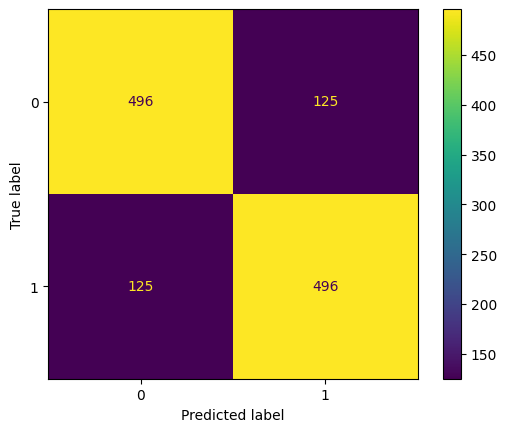

In [15]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], linreg_no_val_predictions)).plot()

In [20]:
(469+475)/(469+475+152+146)

0.7600644122383253

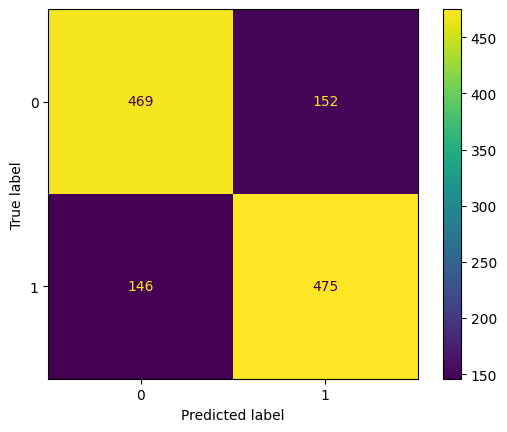

In [19]:
from sklearn.neural_network import MLPClassifier
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

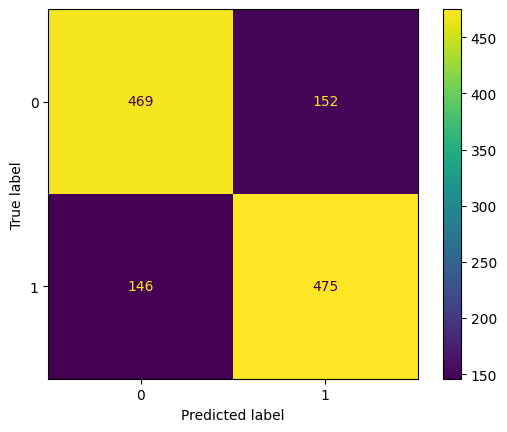

In [21]:
cms = proper_cross_validation(LogisticRegression(), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

The logistic regression model with V4 data is 76% accurate in cross validation. This is better than every bracket in the league from my dad's work (pool of 22, best was 41/63 games right). I could try to engineer more features here, but this is probably good enough. 

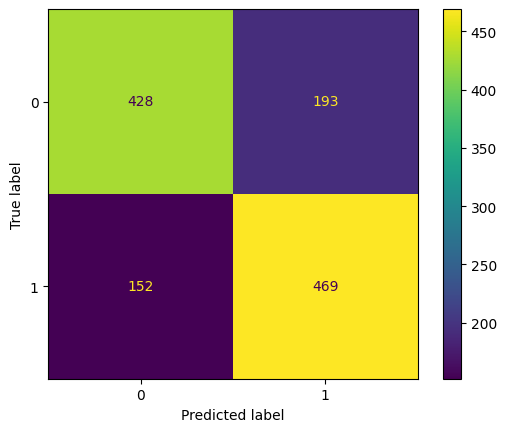

In [22]:
cms = proper_cross_validation(MLPClassifier(hidden_layer_sizes=[50,50], max_iter=3000), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

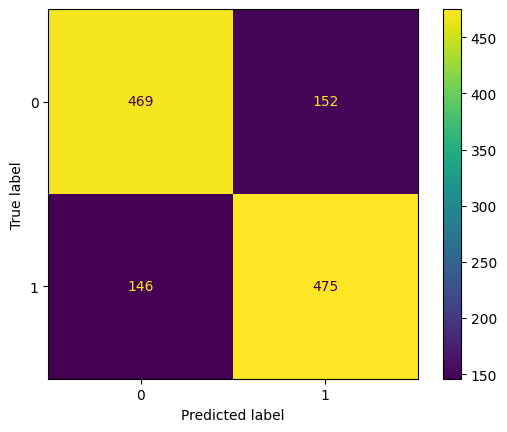

In [25]:
from sklearn.ensemble import RandomForestClassifier
cms = proper_cross_validation(LogisticRegression(), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(prediction_data_normalized)
pd.DataFrame(pca.transform(prediction_data_normalized))

,0,1,2,3,4,5,6,7
0,0.170340,-3.888789,1.206812,-0.993546,2.525121,2.351915,-0.143385,1.211493
1,0.509959,-1.453768,3.438238,1.387529,3.494086,2.030893,0.961254,1.206483
2,1.374016,-1.057081,1.738747,2.703343,5.386657,0.431619,1.109657,1.614596
3,3.224277,-0.986238,3.017765,1.217350,0.930284,0.418903,-0.760613,2.154885
4,3.687896,-0.738947,1.598456,2.698713,1.004144,0.330104,0.116781,2.809941
...,...,...,...,...,...,...,...,...
1237,-1.510880,-0.084885,-1.374282,-2.530306,0.299249,-1.263066,-0.077207,-0.585402
1238,0.636074,0.566975,1.526491,0.094819,4.284270,0.092792,-2.128431,-1.103939
1239,-0.877716,-0.997131,-0.081168,1.804590,3.703601,1.276340,-2.284637,-1.743079
1240,0.254253,-1.238615,-1.051433,-2.198225,0.952858,1.152928,-0.379510,-2.443272


In [65]:
(465+474)/(465+474+156+147)

0.7560386473429952

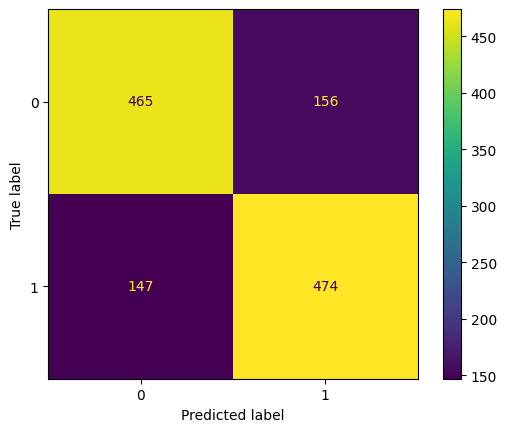

In [64]:
from sklearn.ensemble import AdaBoostClassifier
cms = proper_cross_validation(LogisticRegression(), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [63]:
(426+430)/1242

0.6892109500805152